In [45]:
import pandas as pd
import os
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [47]:
for dirname, _, filenames in os.walk(os.getcwd()):
    for filename in filenames:
        print(os.path.join(dirname, filename))

C:\Users\user\Projects\ML\MachineLearningGroup12\Dataset 2 ECGImageClassification\.DS_Store
C:\Users\user\Projects\ML\MachineLearningGroup12\Dataset 2 ECGImageClassification\ECG image classification.ipynb
C:\Users\user\Projects\ML\MachineLearningGroup12\Dataset 2 ECGImageClassification\.ipynb_checkpoints\ECG image classification-checkpoint.ipynb
C:\Users\user\Projects\ML\MachineLearningGroup12\Dataset 2 ECGImageClassification\ECG_DATA\.DS_Store
C:\Users\user\Projects\ML\MachineLearningGroup12\Dataset 2 ECGImageClassification\ECG_DATA\test\.DS_Store
C:\Users\user\Projects\ML\MachineLearningGroup12\Dataset 2 ECGImageClassification\ECG_DATA\test\ECG Images of Myocardial Infarction Patients (240x12=2880)\MI(1).jpg
C:\Users\user\Projects\ML\MachineLearningGroup12\Dataset 2 ECGImageClassification\ECG_DATA\test\ECG Images of Myocardial Infarction Patients (240x12=2880)\MI(10).jpg
C:\Users\user\Projects\ML\MachineLearningGroup12\Dataset 2 ECGImageClassification\ECG_DATA\test\ECG Images of Myoc

In [49]:
train_dir = 'ECG_DATA/train'
test_dir = 'ECG_DATA/test'

In [51]:
def get_subfolders_and_image_counts(directory):
    subfolders = {}
    for subdir, dirs, files in os.walk(directory):
        if dirs:
            for folder in dirs:
                folder_path = os.path.join(subdir, folder)
                num_images = len([file for file in os.listdir(folder_path) if file.endswith(('.png', '.jpg', '.jpeg'))])
                subfolders[folder] = num_images
    return subfolders

train_subfolders = get_subfolders_and_image_counts(train_dir)
test_subfolders = get_subfolders_and_image_counts(test_dir)

In [53]:
print("Training Subfolders and Image Counts:")
for folder, count in train_subfolders.items():
    print(f"{folder}: {count} images")

print("\nTest Subfolders and Image Counts:")
for folder, count in test_subfolders.items():
    print(f"{folder}: {count} images")

Training Subfolders and Image Counts:
ECG Images of Myocardial Infarction Patients (240x12=2880): 956 images
ECG Images of Patient that have abnormal heartbeat (233x12=2796): 699 images
ECG Images of Patient that have History of MI (172x12=2064): 516 images
Normal Person ECG Images (284x12=3408): 852 images

Test Subfolders and Image Counts:
ECG Images of Myocardial Infarction Patients (240x12=2880): 239 images
ECG Images of Patient that have abnormal heartbeat (233x12=2796): 233 images
ECG Images of Patient that have History of MI (172x12=2064): 172 images
Normal Person ECG Images (284x12=3408): 284 images


In [55]:
# Data Augmentation using Image Data Generator

In [57]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  
    ,rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'

)

test_datagen = ImageDataGenerator(rescale=1./255)

In [67]:
def dataGenerator(train_dir,test_dir):
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),  
        batch_size=32,
        class_mode='categorical',color_mode='grayscale', # Clss_mode = 'categorical 'simplifies that its one hot encoded
        subset='training'  
    )

    validation_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',color_mode='grayscale',
        subset='validation'  
    )
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),color_mode='grayscale',
        batch_size=32,
        class_mode='categorical'
    )

    return train_generator,validation_generator, test_generator
# print("Class indices:", train_generator.class_indices)

In [69]:
trainGenerated, validationGenerated, testGenerated = dataGenerator(train_dir,test_dir)

Found 2420 images belonging to 4 classes.
Found 603 images belonging to 4 classes.
Found 928 images belonging to 4 classes.


In [71]:
print("Class indices:", trainGenerated.class_indices)

Class indices: {'ECG Images of Myocardial Infarction Patients (240x12=2880)': 0, 'ECG Images of Patient that have History of MI (172x12=2064)': 1, 'ECG Images of Patient that have abnormal heartbeat (233x12=2796)': 2, 'Normal Person ECG Images (284x12=3408)': 3}


In [73]:
def graphs(history): 
    # Accuracy plot
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Loss plot
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [75]:
def mlpModelFun(trainGenerated, validationGenerated):
    mlpModel = models.Sequential([
        layers.Input(shape=(224, 224, 1)),
        layers.Flatten(),

        layers.Dense(256,activation='relu'),
        layers.Dropout(0.1),

        layers.Dense(128,activation='relu'),
        layers.Dropout(0.1),

        layers.Dense(64,activation='relu'),
        layers.Dropout(0.1),

        layers.Dense(len(trainGenerated.class_indices), activation='softmax')
    ])

    mlpModel.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    
    history = mlpModel.fit(
    trainGenerated,
    steps_per_epoch=trainGenerated.samples // trainGenerated.batch_size,
    validation_data=validationGenerated,
    validation_steps=validationGenerated.samples // validationGenerated.batch_size,
    epochs=25  
    )
    return history

C:\Users\user\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 301s 4s/step - accuracy: 0.2807 - loss: 9.8878 - val_accuracy: 0.2847 - val_loss: 1.3849
Epoch 2/25
 1/75 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.1875 - loss: 1.3884

C:\Users\user\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.1875 - loss: 1.3884 - val_accuracy: 0.2222 - val_loss: 1.3863
Epoch 3/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 313s 4s/step - accuracy: 0.2790 - loss: 1.4121 - val_accuracy: 0.2830 - val_loss: 1.3712
Epoch 4/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.2188 - loss: 1.3875 - val_accuracy: 0.2593 - val_loss: 1.3736
Epoch 5/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 248s 3s/step - accuracy: 0.2896 - loss: 1.3914 - val_accuracy: 0.2743 - val_loss: 1.3646
Epoch 6/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.2188 - loss: 1.3740 - val_accuracy: 0.4444 - val_loss: 1.3587
Epoch 7/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 260s 3s/step - accuracy: 0.3003 - loss: 1.3621 - val_accuracy: 0.3160 - val_loss: 1.3639
Epoch 8/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.5312 - loss: 1.2894 - val_accuracy: 0.3333 - val_loss: 1.3166
Epoch 9/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 277s 4s/step - accuracy: 0.3104 - loss: 1.3624 - val_accuracy: 0.3229 - val_loss: 1.

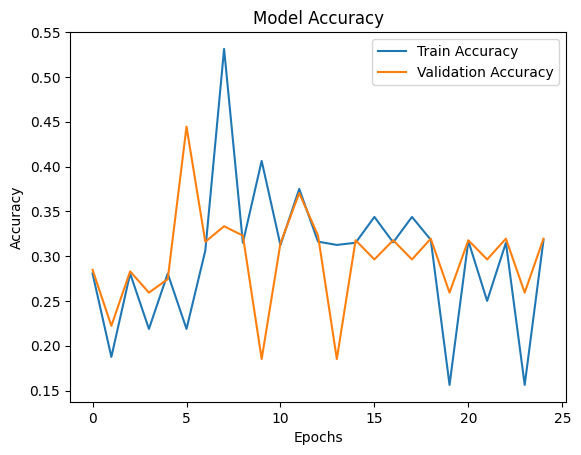

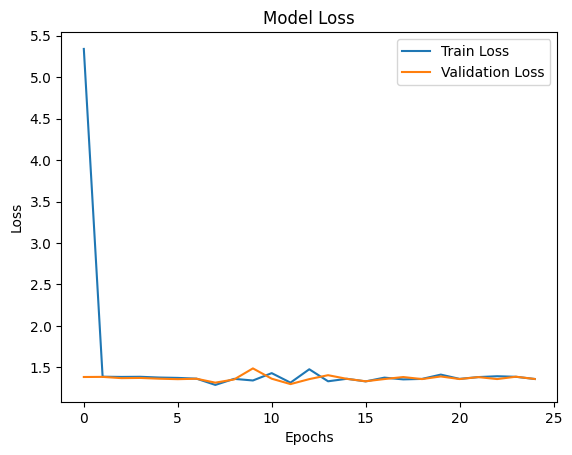

In [77]:
mlpModelHistory = mlpModelFun(trainGenerated, validationGenerated)
graphs(mlpModelHistory)